In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/can-i-be-an-influencer/sample_submission.csv
/kaggle/input/can-i-be-an-influencer/test_colors.csv
/kaggle/input/can-i-be-an-influencer/test_keywords.csv
/kaggle/input/can-i-be-an-influencer/train.csv
/kaggle/input/can-i-be-an-influencer/train_colors.csv
/kaggle/input/can-i-be-an-influencer/test.csv
/kaggle/input/can-i-be-an-influencer/train_keywords.csv


In [ ]:
# Data handling and processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Set up for inline plotting
%matplotlib inline

# Set global styling options for visualizations
sns.set(style='whitegrid', palette='muted')


In [ ]:
train_keyword=pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_keywords.csv')
train_keyword.head()
len(np.unique(train_keyword['image_id']))/len(train_keyword)

0.009447480775069867

In [ ]:
def top_5_matches(train_keyword):
    top_5 = train_keyword.sort_values('confidence_value', ascending=False).head(5)
    matches = train_keyword[train_keyword.duplicated(subset='classification_keyword', keep=False)]
    return pd.concat([top_5, matches], ignore_index=True)

# group by ID and apply the function to each group
output = train_keyword.groupby('image_id').apply(top_5_matches)
output.index=range(len(output))

In [ ]:
train_keyword.drop(["image_classification"],axis=1,inplace=True)

In [ ]:
grouped_key = output.groupby('image_id')['classification_keyword'].agg(list).to_frame().reset_index()
grouped_conf = output.groupby('image_id')['confidence_value'].agg(list).to_frame().reset_index()

In [ ]:
result = pd.merge(grouped_key, grouped_conf, on='image_id')

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Set the path to the dataset you added
BERT_MODEL_PATH = '/kaggle/input/bert-base-uncased'

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_PATH)


Some weights of the model checkpoint at /kaggle/input/bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [ ]:
def word_embed(input_text):
    tokens = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model.bert(tokens)
        embeddings = outputs[0][0]
    feature = embeddings.mean(dim=0)[:10]

    return feature


In [ ]:
p={x for l in list(result["classification_keyword"]) for x in l}
from tqdm import tqdm
dict_val={}
for i in tqdm(list(p)):
    dict_val[i]=word_embed(i)

100%|██████████| 1464/1464 [01:05<00:00, 22.22it/s]


In [ ]:
from tqdm import tqdm
c = result["classification_keyword"]
n = len(result)
features = np.zeros((n, 10))

for i in tqdm(range(n)):
    val = np.array([dict_val[w] for w in c[i]])
    features[i] = np.sum(val, axis=0) / 5

  0%|          | 0/12197 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
100%|██████████| 12197/12197 [00:00<00:00, 12596.06it/s]


In [ ]:
result['features']=features.tolist()
result = pd.concat([result.drop('features', axis=1), result['features'].apply(lambda x: pd.Series(x))], axis=1)

In [ ]:
result.drop(["classification_keyword","confidence_value"],axis=1,inplace=True)

In [ ]:
result.columns=['image_id', "k0", "k1", "k2", "k3", "k4", "k5", "k6", "k7", "k8", "k9"]

In [ ]:
result

,image_id,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9
0,000060f5b4,0.069015,0.058841,-0.252575,-0.068722,0.169969,-0.137746,0.351860,0.407347,-0.098325,-0.343947
1,00048eb0af,0.190560,0.069967,-0.225494,-0.064672,0.130371,-0.101041,0.317389,0.254252,0.059672,-0.203163
2,000a71e54b,0.070609,0.043138,-0.235401,-0.015563,-0.042942,-0.184112,0.446267,0.147009,-0.043250,-0.253750
3,000ad1b637,0.090760,0.061194,-0.240915,0.039106,0.007372,-0.201592,0.334359,0.041467,-0.025941,-0.246241
4,00192ccaaa,0.161085,0.024733,-0.153610,0.066934,0.075836,-0.183955,0.306282,0.103451,-0.137456,-0.264569
...,...,...,...,...,...,...,...,...,...,...,...
12192,ffe1a4b194,0.000698,0.006132,-0.219800,-0.123611,0.074024,-0.190222,0.420785,0.243868,0.133162,-0.112426
12193,ffe4d6ea46,-0.001521,0.057119,-0.338645,-0.018830,0.091317,-0.079224,0.416252,0.269993,-0.071059,-0.201397
12194,ffe7b6ae59,0.095380,0.158333,-0.380324,-0.005830,0.328644,-0.000991,0.201215,0.472544,-0.178813,-0.094123
12195,ffed1eaaba,0.076098,0.060391,-0.282235,0.013369,0.110870,-0.118108,0.360715,0.153133,-0.020955,-0.300283


Preprocessing Train Colors

In [ ]:
train_df = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train.csv')
train_colors_df = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_colors.csv')

In [ ]:
num_unique_keywords = train_colors_df['keyword'].nunique()
print(f'Number of unique keywords(colors) in train_colors: {num_unique_keywords}')

Number of unique keywords(colors) in train_colors: 139


In [ ]:
keyword_counts = train_colors_df['keyword'].value_counts()
threshold = 0.05 * train_colors_df['image_id'].nunique()
keywords_to_keep = keyword_counts[keyword_counts >= threshold].index
filtered_train_colors = train_colors_df[train_colors_df['keyword'].isin(keywords_to_keep)]
print(filtered_train_colors.head())

     image_id    R    G    B image_hex         keyword  pixel_coverage  \
0  34d72beca9   69  112  154    45709A       steelblue        0.130267   
1  547eda8452  132  162   88    84A258            gray        0.035833   
2  f6200aa06c  189  192  194    BDC0C2          silver        0.077500   
3  eb8b9707b6   34   31   14    221F0E           black        0.058533   
4  772ada1ab7   98   81   55    625137  darkolivegreen        0.022112   

   color_score  
0     0.093075  
1     0.192869  
2     0.040238  
3     0.159234  
4     0.175522  


In [ ]:
color_map = {
    'AliceBlue': 'LightBlue',
    'AntiqueWhite': 'Beige',
    'Aqua': 'Cyan',
    'Aquamarine': 'Green',
    'Azure': 'LightBlue',
    'Beige': 'Tan',
    'Bisque': 'Tan',
    'Black': 'Black',
    'BlanchedAlmond': 'Tan',
    'Blue': 'Blue',
    'BlueViolet': 'Purple',
    'Brown': 'Brown',
    'BurlyWood': 'Tan',
    'CadetBlue': 'Blue',
    'Chartreuse': 'Green',
    'Chocolate': 'Brown',
    'Coral': 'Orange',
    'CornflowerBlue': 'Blue',
    'Cornsilk': 'Beige',
    'Crimson': 'Red',
    'Cyan': 'Cyan',
    'DarkBlue': 'Blue',
    'DarkCyan': 'Cyan',
    'DarkGoldenrod': 'Brown',
    'DarkGray': 'Gray',
    'DarkGrey': 'Gray',
    'DarkGreen': 'Green',
    'DarkKhaki': 'Tan',
    'DarkMagenta': 'Purple',
    'DarkOliveGreen': 'Green',
    'DarkOrange': 'Orange',
    'DarkOrchid': 'Purple',
    'DarkRed': 'Red',
    'DarkSalmon': 'Orange',
    'DarkSeaGreen': 'Green',
    'DarkSlateBlue': 'Blue',
    'DarkSlateGray': 'Gray',
    'DarkSlateGrey': 'Gray',
    'DarkTurquoise': 'Cyan',
    'DarkViolet': 'Purple',
    'DeepPink': 'Pink',
    'DeepSkyBlue': 'Blue',
    'DimGray': 'Gray',
    'DimGrey': 'Gray',
    'DodgerBlue': 'Blue',
    'FireBrick': 'Red',
    'FloralWhite': 'Beige',
    'ForestGreen': 'Green',
    'Fuchsia': 'Purple',
    'Gainsboro': 'Gray',
    'GhostWhite': 'White',
    'Gold': 'Yellow',
    'Goldenrod': 'Yellow',
    'Gray': 'Gray',
    'Grey': 'Gray',
    'Green': 'Green',
    'GreenYellow': 'Green',
    'Honeydew': 'LightGreen',
    'HotPink': 'Pink',
    'IndianRed': 'Red',
    'Indigo': 'Purple',
    'Ivory': 'White',
    'Khaki': 'Tan',
    'Lavender': 'Purple',
    'LavenderBlush': 'Pink',
    'LawnGreen': 'Green',
    'LemonChiffon': 'Yellow',
    'LightBlue': 'LightBlue',
    'LightCoral': 'Pink',
    'LightCyan': 'Cyan',
    'LightGoldenrodYellow': 'Yellow',
    'LightGray': 'Gray',
    'LightGrey': 'Gray',
    'LightGreen': 'LightGreen',
    'LightPink': 'Pink',
    'LightSalmon': 'Orange',
    'LightSeaGreen': 'Green',
    'LightSkyBlue': 'LightBlue',
    'LightSlateGray': 'Gray',
    'LightSlateGrey': 'Gray',
    'LightSteelBlue': 'LightBlue',
    'LightYellow': 'Yellow',
    'Lime': 'Green',
    'LimeGreen': 'Green',
    'Linen': 'Beige',
    'Magenta': 'Purple',
    'Maroon': 'Red',
    'MediumAquamarine': 'Green',
    'MediumBlue': 'Blue',
    'MediumOrchid': 'Purple',
    'MediumPurple': 'Purple',
    'MediumSeaGreen': 'Green',
    'MediumSlateBlue': 'Blue',
    'MediumSpringGreen': 'Green',
    'MediumTurquoise': 'Cyan',
    'MediumVioletRed': 'Red',
    'MidnightBlue': 'Blue',
    'MintCream': 'LightGreen',
    'MistyRose': 'Pink',
    'Moccasin': 'Tan',
    'NavajoWhite': 'Tan',
    'Navy': 'Blue',
    'OldLace': 'Beige',
    'Olive': 'Green',
    'OliveDrab': 'Green',
    'Orange': 'Orange',
    'OrangeRed': 'Red',
    'Orchid': 'Purple',
    'PaleGoldenrod': 'Yellow',
    'PaleGreen': 'LightGreen',
    'PaleTurquoise': 'Cyan',
    'PaleVioletRed': 'Pink',
    'PapayaWhip': 'Yellow',
    'PeachPuff': 'Orange',
    'Peru': 'Brown',
    'Pink': 'Pink',
    'Plum': 'Purple',
    'PowderBlue': 'LightBlue',
    'Purple': 'Purple',
    'Red': 'Red',
    'RosyBrown': 'Brown',
    'RoyalBlue': 'Blue',
    'SaddleBrown': 'Brown',
    'Salmon': 'Orange',
    'SandyBrown': 'Brown',
    'SeaGreen': 'Green',
    'Seashell': 'Beige',
    'Sienna': 'Brown',
    'Silver': 'Gray',
    'SkyBlue': 'LightBlue',
    'SlateBlue': 'Blue',
    'SlateGray': 'Gray',
    'SlateGrey': 'Gray',
    'Snow': 'White',
    'SpringGreen': 'Green',
    'SteelBlue': 'Blue',
    'Tan': 'Tan',
    'Teal': 'Green',
    'Thistle': 'Purple',
    'Tomato': 'Red',
    'Turquoise': 'Cyan',
    'Violet': 'Purple',
    'Wheat': 'Tan',
    'White': 'White',
    'WhiteSmoke': 'Gray',
    'Yellow': 'Yellow',
    'YellowGreen': 'Green'
}

In [ ]:
color_map = {key.lower(): value for key, value in color_map.items()}
filtered_train_colors['keyword'] = filtered_train_colors['keyword'].map(lambda x: color_map.get(x, x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
colors_pivot = filtered_train_colors.pivot_table(
    index='image_id',
    columns='keyword',
    values='color_score',
    fill_value=0,
).reset_index()
colors_pivot

keyword,image_id,Black,Blue,Brown,Gray,Green,LightBlue,Purple,Red,Tan,Yellow
0,000060f5b4,0.000000,0.000000,0.111094,0.093822,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,00048eb0af,0.050951,0.000000,0.000000,0.135712,0.071086,0.000000,0.000000,0.000000,0.0,0.0
2,000a71e54b,0.000000,0.000000,0.101036,0.042046,0.018547,0.000000,0.000000,0.089691,0.0,0.0
3,000ad1b637,0.041266,0.000000,0.000000,0.100134,0.051427,0.000000,0.234921,0.000000,0.0,0.0
4,00192ccaaa,0.138489,0.000000,0.066744,0.061385,0.055479,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12166,ffe1a4b194,0.000000,0.000000,0.105582,0.165083,0.000000,0.000000,0.000000,0.033172,0.0,0.0
12167,ffe4d6ea46,0.000000,0.000000,0.152976,0.095355,0.000000,0.000000,0.000000,0.000000,0.0,0.0
12168,ffe7b6ae59,0.000000,0.052698,0.000000,0.091663,0.000000,0.000000,0.000000,0.000000,0.0,0.0
12169,ffed1eaaba,0.036532,0.054405,0.054947,0.040460,0.057236,0.132532,0.000000,0.000000,0.0,0.0


In [ ]:
merged_df = train_df.merge(colors_pivot, on='image_id')
merged_df.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,Black,Blue,Brown,Gray,Green,LightBlue,Purple,Red,Tan,Yellow
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,0.058346,0.000000,0.000000,0.054235,0.059854,0.000000,0.000000,0.0,0.000000,0.0
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,0.000000,0.000000,0.000000,0.027330,0.000000,0.031453,0.000000,0.0,0.044115,0.0
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,0.098444,0.000000,0.000000,0.114931,0.021847,0.000000,0.000000,0.0,0.000000,0.0
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,0.000000,0.000000,0.005947,0.109897,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,0.000000,0.083888,0.123279,0.012219,0.000000,0.000000,0.007103,0.0,0.056609,0.0


In [ ]:
columns_to_remove = ['photo_url', 'photo_image_url', 'photo_submitted_at', 'description1', 'description2', 'latitude', 'longitude', 'camera_model']
merged_df = merged_df.drop(columns=columns_to_remove)

In [ ]:
#Dealing with NAs in 2 columns by replacing with most common value as there were less NAs
merged_df['camera_make'].fillna(merged_df['camera_make'].mode()[0], inplace=True)
merged_df['iso'].fillna(merged_df['iso'].mean(), inplace=True)
merged_df['aperture_value'].fillna(merged_df['aperture_value'].mean(), inplace=True)
# Convert exposure_time to numeric
merged_df['exposure_time'] = pd.to_numeric(merged_df['exposure_time'], errors='coerce')

# Fill missing values with the mean
merged_df['exposure_time'].fillna(merged_df['exposure_time'].mean(), inplace=True)
# Setting the image_id column as the index
merged_df.set_index('image_id', inplace=True)

In [ ]:
merged_df

,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,iso,...,Black,Blue,Brown,Gray,Green,LightBlue,Purple,Red,Tan,Yellow
image_id,,,,,,,,,,,,,,,,,,,,,
68105c019b,Thursday,15,13,10,Featured,2592,1728,1.50,Canon,200.0,...,0.058346,0.000000,0.000000,0.054235,0.059854,0.000000,0.000000,0.0,0.000000,0.0
06d11c4edd,Wednesday,21,59,51,Featured,4000,6000,0.67,SONY,100.0,...,0.000000,0.000000,0.000000,0.027330,0.000000,0.031453,0.000000,0.0,0.044115,0.0
f6599edba1,Tuesday,4,10,11,Featured,5504,8256,0.67,NIKON CORPORATION,64.0,...,0.098444,0.000000,0.000000,0.114931,0.021847,0.000000,0.000000,0.0,0.000000,0.0
0f4bcc2d36,Monday,23,46,21,Featured,3627,2040,1.78,DJI,139.0,...,0.000000,0.000000,0.005947,0.109897,0.000000,0.000000,0.000000,0.0,0.000000,0.0
74db502ed5,Saturday,11,4,20,Featured,4896,3264,1.50,FUJIFILM,400.0,...,0.000000,0.083888,0.123279,0.012219,0.000000,0.000000,0.007103,0.0,0.056609,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18eaca644e,Monday,13,7,25,Featured,4480,6111,0.73,Canon,100.0,...,0.000000,0.000000,0.000000,0.047403,0.075239,0.000000,0.000000,0.0,0.129929,0.0
eb25cd769e,Monday,20,32,28,Featured,2403,3337,0.72,Canon,400.0,...,0.052166,0.000000,0.116083,0.051741,0.052664,0.000000,0.000000,0.0,0.032104,0.0
73302461d0,Thursday,1,54,16,Featured,5184,3456,1.50,Canon,400.0,...,0.000000,0.023177,0.000000,0.040671,0.000000,0.207078,0.000000,0.0,0.000000,0.0


In [ ]:
def standardize_camera_make(df, pattern, standardized_name):
    df.loc[df['camera_make'].str.contains(pattern, case=False, na=False), 'camera_make'] = standardized_name

patterns_to_standardize = [
    (r'\b[Cc][Aa][Nn][Oo][Nn]\b', 'Canon'),
    (r'\b[Nn][Ii][Kk][Oo][Nn]\b', 'Nikon'),
    (r'\b[Ss][Aa][Mm][Ss][Uu][Nn][Gg]\b', 'Samsung'),
    (r'\b[Ss][Oo][Nn][Yy]\b', 'Sony'),
    (r'\b[Pp][Ee][Nn][Tt][Aa][Xx]\b', 'Pentax'),
    (r'\b[Mm][Oo][Tt][Oo][Rr][Oo][Ll][Aa]\b', 'Motorola'),
    (r'\b[Ff][Uu][Jj][Ii][Ff][Ii][Ll][Mm]\b', 'Fujifilm'),
    (r'\b[Oo][Ll][Yy][Mm][Pp][Uu][Ss]\b', 'Olympus'),
    (r'\b[Ll][Ee][Ii][Cc][Aa]\b', 'Leica'),
    (r'\b[Hh][Aa][Ss][Ss][Ee][Ll][Bb][Ll][Aa][Dd]\b', 'Hasselblad'),
    (r'\b[Dd][Jj][Ii]\b', 'DJI'),
    (r'\b[Gg][Oo][Pp][Rr][Oo]\b', 'GoPro'),
]

for pattern, standardized_name in patterns_to_standardize:
    standardize_camera_make(merged_df, pattern, standardized_name)

merged_df['camera_make'] = merged_df['camera_make'].replace(['XIAOYI'], 'YI TECHNOLOGY')

In [ ]:
import re
def replace_zwo(name):
    if re.search("ZWO", name, re.IGNORECASE):
        return "ZWO"
    return name

merged_df['camera_make'] = merged_df['camera_make'].apply(replace_zwo)

def replace_google(name):
    if re.search("Google", name, re.IGNORECASE):
        return "Google"
    return name

merged_df['camera_make'] = merged_df['camera_make'].apply(replace_google)

In [ ]:
merged_df

,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,iso,...,Black,Blue,Brown,Gray,Green,LightBlue,Purple,Red,Tan,Yellow
image_id,,,,,,,,,,,,,,,,,,,,,
68105c019b,Thursday,15,13,10,Featured,2592,1728,1.50,Canon,200.0,...,0.058346,0.000000,0.000000,0.054235,0.059854,0.000000,0.000000,0.0,0.000000,0.0
06d11c4edd,Wednesday,21,59,51,Featured,4000,6000,0.67,Sony,100.0,...,0.000000,0.000000,0.000000,0.027330,0.000000,0.031453,0.000000,0.0,0.044115,0.0
f6599edba1,Tuesday,4,10,11,Featured,5504,8256,0.67,Nikon,64.0,...,0.098444,0.000000,0.000000,0.114931,0.021847,0.000000,0.000000,0.0,0.000000,0.0
0f4bcc2d36,Monday,23,46,21,Featured,3627,2040,1.78,DJI,139.0,...,0.000000,0.000000,0.005947,0.109897,0.000000,0.000000,0.000000,0.0,0.000000,0.0
74db502ed5,Saturday,11,4,20,Featured,4896,3264,1.50,Fujifilm,400.0,...,0.000000,0.083888,0.123279,0.012219,0.000000,0.000000,0.007103,0.0,0.056609,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18eaca644e,Monday,13,7,25,Featured,4480,6111,0.73,Canon,100.0,...,0.000000,0.000000,0.000000,0.047403,0.075239,0.000000,0.000000,0.0,0.129929,0.0
eb25cd769e,Monday,20,32,28,Featured,2403,3337,0.72,Canon,400.0,...,0.052166,0.000000,0.116083,0.051741,0.052664,0.000000,0.000000,0.0,0.032104,0.0
73302461d0,Thursday,1,54,16,Featured,5184,3456,1.50,Canon,400.0,...,0.000000,0.023177,0.000000,0.040671,0.000000,0.207078,0.000000,0.0,0.000000,0.0


In [ ]:
result.set_index('image_id',inplace=True)

In [ ]:
merged_df=merged_df.merge(result,how='inner',left_index=True,right_index=True)

In [ ]:
merged_df

,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,iso,...,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9
image_id,,,,,,,,,,,,,,,,,,,,,
68105c019b,Thursday,15,13,10,Featured,2592,1728,1.50,Canon,200.0,...,0.073833,0.010403,-0.177644,-0.022963,0.170512,-0.159979,0.265582,0.274522,0.029648,-0.086307
06d11c4edd,Wednesday,21,59,51,Featured,4000,6000,0.67,Sony,100.0,...,0.089505,0.094751,-0.212163,-0.020146,0.166383,-0.146509,0.279071,0.136417,-0.084186,-0.312028
f6599edba1,Tuesday,4,10,11,Featured,5504,8256,0.67,Nikon,64.0,...,0.050792,0.014363,-0.226375,-0.048563,0.057708,-0.141746,0.388650,0.247486,-0.006421,-0.283690
0f4bcc2d36,Monday,23,46,21,Featured,3627,2040,1.78,DJI,139.0,...,0.161085,0.024733,-0.153610,0.066934,0.075836,-0.183955,0.306282,0.103451,-0.137456,-0.264569
74db502ed5,Saturday,11,4,20,Featured,4896,3264,1.50,Fujifilm,400.0,...,-0.000794,0.112619,-0.165082,0.056763,0.127750,-0.205938,0.288170,0.204767,-0.088140,-0.335079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18eaca644e,Monday,13,7,25,Featured,4480,6111,0.73,Canon,100.0,...,0.110843,0.114554,-0.179067,0.012461,0.106730,-0.150459,0.372250,0.176356,-0.054191,-0.289648
eb25cd769e,Monday,20,32,28,Featured,2403,3337,0.72,Canon,400.0,...,0.057266,0.001224,-0.244264,-0.019457,-0.033789,-0.050432,0.393345,0.146545,-0.049207,-0.192282
73302461d0,Thursday,1,54,16,Featured,5184,3456,1.50,Canon,400.0,...,0.209892,-0.019640,-0.162948,0.075191,0.048513,-0.108916,0.255171,0.063731,-0.119322,-0.252701


In [ ]:
merged_df.columns

Index(['obs_day', 'obs_hour', 'obs_min', 'obs_sec', 'image_category', 'width',
       'height', 'aspect_ratio', 'camera_make', 'iso', 'aperture_value',
       'focal_length', 'exposure_time', 'country', 'city', 'total_days',
       'stats_downloads', 'Black', 'Blue', 'Brown', 'Gray', 'Green',
       'LightBlue', 'Purple', 'Red', 'Tan', 'Yellow', 'k0', 'k1', 'k2', 'k3',
       'k4', 'k5', 'k6', 'k7', 'k8', 'k9'],
      dtype='object')

<AxesSubplot:xlabel='obs_day'>

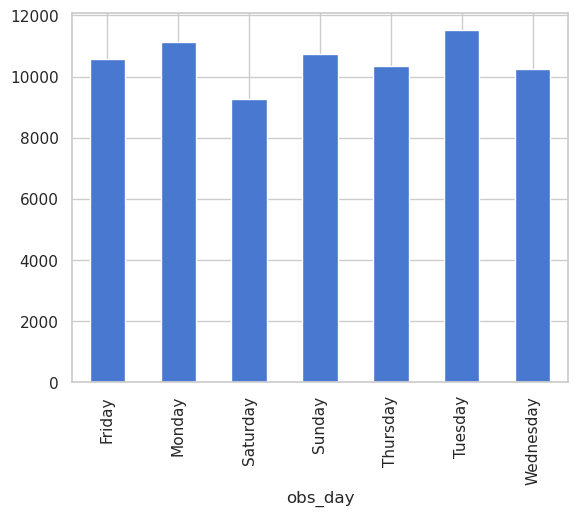

In [ ]:
merged_df.groupby(by = "obs_day")['stats_downloads'].mean().plot(kind = "bar")

<AxesSubplot:xlabel='obs_hour'>

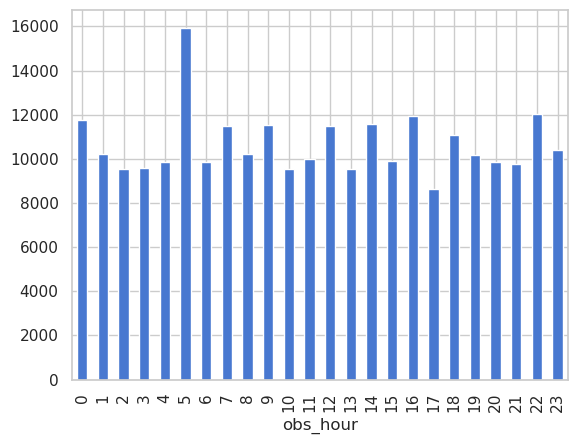

In [ ]:
merged_df.groupby(by = "obs_hour")['stats_downloads'].mean().plot(kind = "bar")

In [ ]:
bins = [-1, 5, 11, 16, 20, 23]
labels = ['night', 'morning', 'afternoon', 'evening', 'night']
merged_df['time_of_day'] = pd.cut(merged_df['obs_hour'], bins=bins, labels=labels,ordered=False)

In [ ]:
merged_df.drop(["obs_day","obs_hour","obs_min","obs_sec"],axis=1,inplace=True)

<AxesSubplot:xlabel='image_category'>

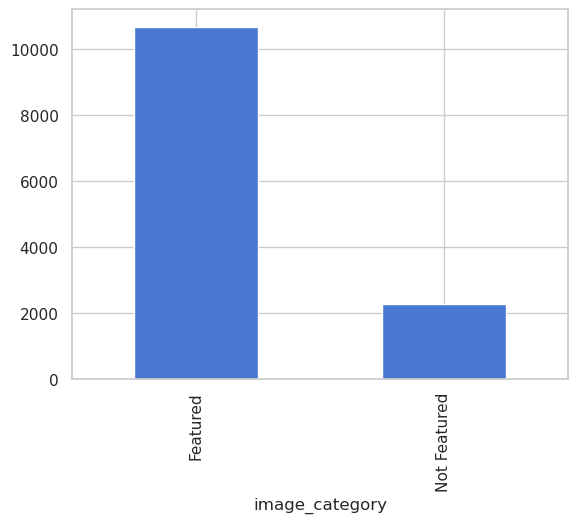

In [ ]:
merged_df.groupby(by = "image_category")['stats_downloads'].mean().plot(kind = "bar")

In [ ]:
merged_df['camera_make'] = merged_df['camera_make'].replace('LG Electronics', 'LGE')
merged_df['camera_make'] = merged_df['camera_make'].replace('Fujica', 'Fujifilm')
merged_df['camera_make'] = merged_df['camera_make'].replace('Xiaomi', 'XIAOMI')
merged_df['camera_make'] = merged_df['camera_make'].replace('Cannon', 'Canon')
merged_df['camera_make'] = merged_df['camera_make'].replace('HUAWEI', 'Huawei')

In [ ]:
np.unique(merged_df["camera_make"])

array(['ADI', 'ASUS', 'Apple', 'Asus', 'Canon', 'DJI', 'DOOGEE',
       'EASTMAN KODAK COMPANY', 'Fujifilm', 'GoPro', 'Google', 'HTC',
       'Hasselblad', 'Huawei', 'InFocus', 'LGE', 'Leaf', 'Leica',
       'Lenovo', 'MAKER NAME', 'Mamiya', 'Meizu', 'Motorola', 'Nikon',
       'Olympus', 'OnePlus', 'Panasonic', 'Parrot', 'Pentax',
       'Phase One A/S', 'RICOH IMAGING COMPANY, LTD.', 'Ricoh', 'SIGMA',
       'Samsung', 'Sony', 'Spectre', 'XIAOMI', 'YI TECHNOLOGY', 'ZWO',
       'Zenit', 'vivo'], dtype=object)

<AxesSubplot:xlabel='camera_make'>

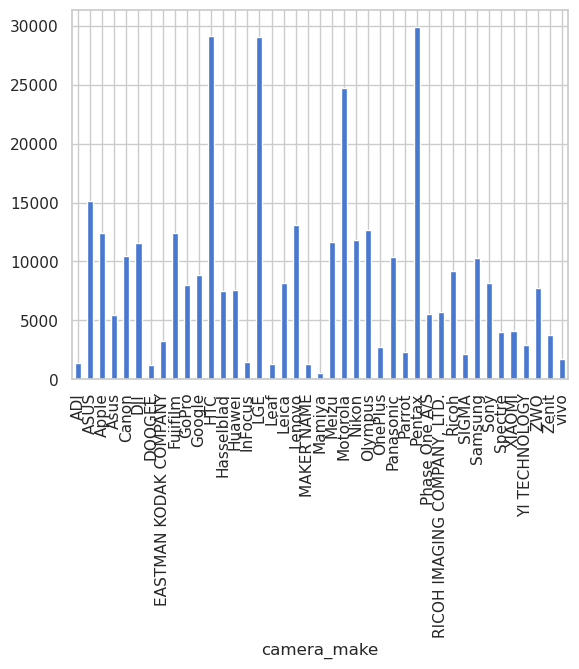

In [ ]:
merged_df.groupby(by = "camera_make")['stats_downloads'].mean().plot(kind = "bar")

In [ ]:
merged_df.isnull().sum()

image_category        0
width                 0
height                0
aspect_ratio          0
camera_make           0
iso                   0
aperture_value        0
focal_length          0
exposure_time         0
country            7891
city               9130
total_days            0
stats_downloads       0
Black                 0
Blue                  0
Brown                 0
Gray                  0
Green                 0
LightBlue             0
Purple                0
Red                   0
Tan                   0
Yellow                0
k0                    0
k1                    0
k2                    0
k3                    0
k4                    0
k5                    0
k6                    0
k7                    0
k8                    0
k9                    0
time_of_day           0
dtype: int64

In [ ]:
merged_df.drop(["country","city"],axis=1,inplace=True)

In [ ]:
merged_df.dtypes

image_category       object
width                 int64
height                int64
aspect_ratio        float64
camera_make          object
iso                 float64
aperture_value      float64
focal_length        float64
exposure_time       float64
total_days            int64
stats_downloads       int64
Black               float64
Blue                float64
Brown               float64
Gray                float64
Green               float64
LightBlue           float64
Purple              float64
Red                 float64
Tan                 float64
Yellow              float64
k0                  float64
k1                  float64
k2                  float64
k3                  float64
k4                  float64
k5                  float64
k6                  float64
k7                  float64
k8                  float64
k9                  float64
time_of_day        category
dtype: object

In [ ]:
cols_to_transform=['image_category',"time_of_day"]
dummies = pd.get_dummies(merged_df[cols_to_transform])
merged_df = pd.concat([merged_df, dummies], axis=1)



In [ ]:
merged_df.columns

Index(['image_category', 'width', 'height', 'aspect_ratio', 'camera_make',
       'iso', 'aperture_value', 'focal_length', 'exposure_time', 'total_days',
       'stats_downloads', 'Black', 'Blue', 'Brown', 'Gray', 'Green',
       'LightBlue', 'Purple', 'Red', 'Tan', 'Yellow', 'k0', 'k1', 'k2', 'k3',
       'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'time_of_day',
       'image_category_Featured', 'image_category_Not Featured',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night'],
      dtype='object')

In [ ]:
# drop the original categorical columns
merged_df.drop(cols_to_transform, axis=1, inplace=True)

In [ ]:
merged_df.drop(['aspect_ratio','camera_make', 'exposure_time'],axis=1,inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
mm = RobustScaler()
c=['width', 'height',  'iso', 'aperture_value',
       'focal_length', 'total_days',
       'Black', 'Blue', 'Brown', 'Gray', 'Green', 'LightBlue', 'Purple', 'Red',
       'Tan', 'Yellow', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8',
       'k9']
merged_df[c] = mm.fit_transform(merged_df[c])

In [ ]:
X=merged_df.drop(['stats_downloads'],axis=1)
y=merged_df['stats_downloads']

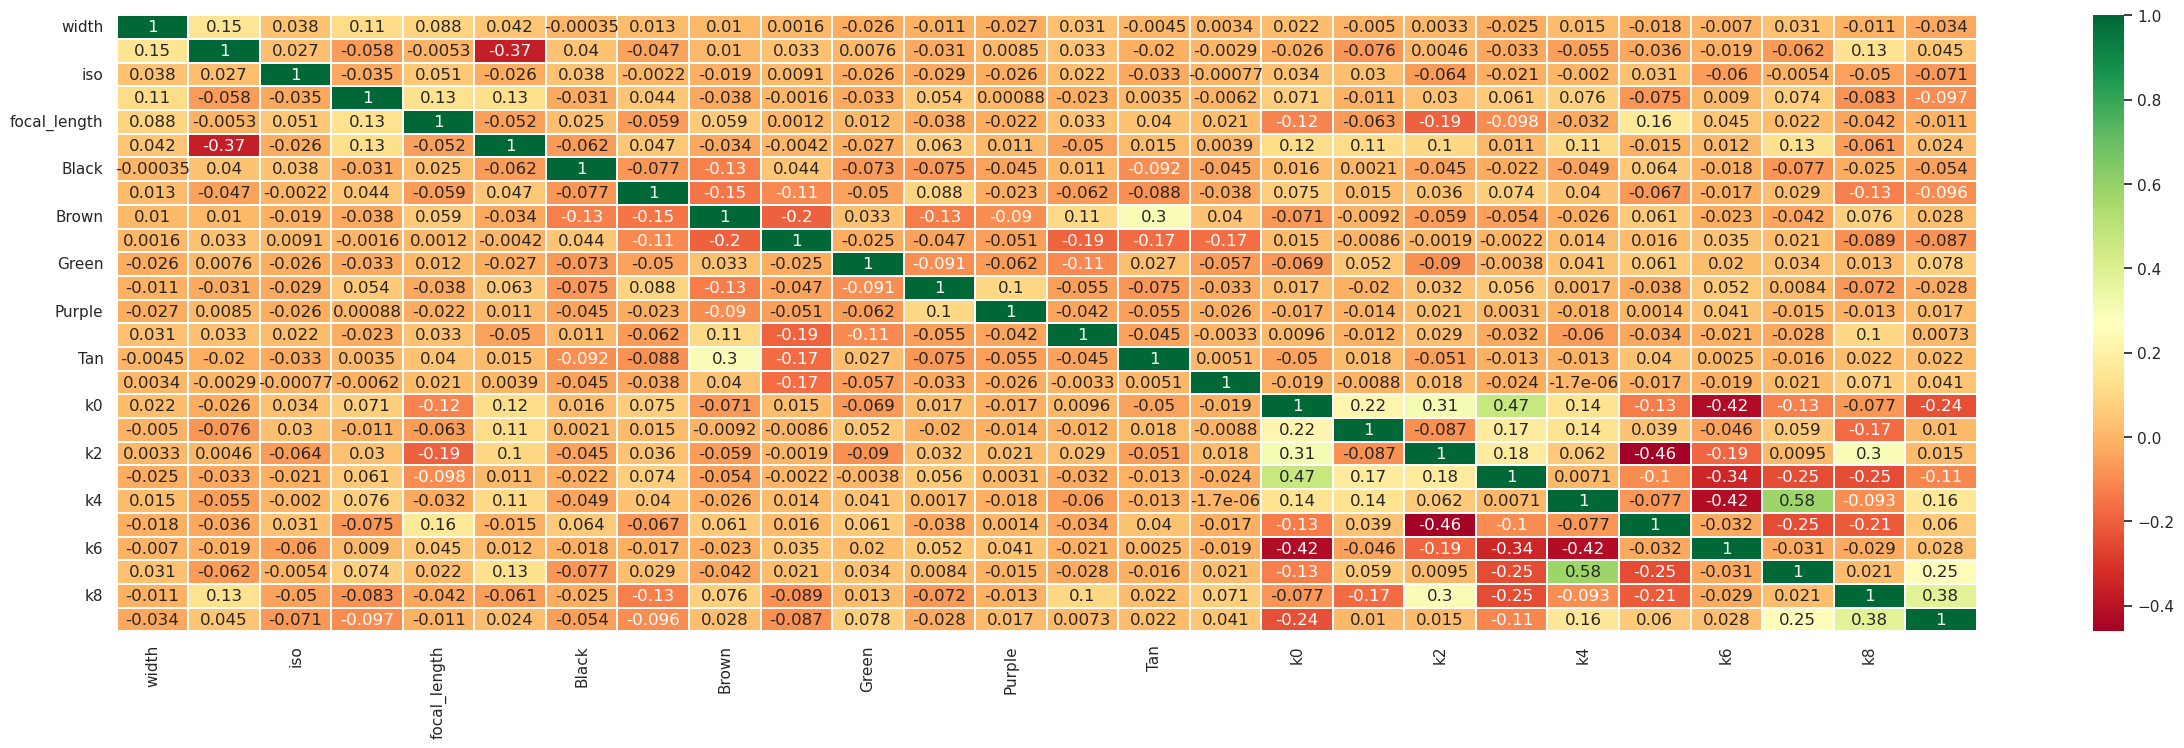

In [ ]:
sns.heatmap(X[c].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(30,8)
plt.show()


In [ ]:
#from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 100)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Perform ANOVA feature selection
selector = SelectKBest(f_regression, k=25)
X_new = selector.fit_transform(X, y)

# Get the column indices of the selected features
selected_features = selector.get_support(indices=True)

# Create a DataFrame with only the selected features
X_selected = pd.DataFrame(X_new, columns=[X.columns[i] for i in selected_features])

# Split the selected features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train the linear regression model on the training data
reg = LinearRegression().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 27583.858514019794
R^2: 0.113573718288832
Adjusted R^2: 0.10437460785181285


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train the SVR model on the training data
reg = SVR().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 30032.10675045062
R^2: -0.05076158985792745
Adjusted R^2: -0.061666131056121065


In [ ]:
!pip install xgboost

import xgboost as xgb
# Train the XGBoost model on the training data
reg = xgb.XGBRegressor().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 29676.584982327175
R^2: -0.02603089359106381
Adjusted R^2: -0.03667878580350736


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest model on the training data
reg = RandomForestRegressor().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 28097.151243835568
R^2: 0.08027674126286655
Adjusted R^2: 0.07073208311906076


In [ ]:
!pip install catboost

import catboost as cb

# Train the CatBoost model on the training data
reg = cb.CatBoostRegressor().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Learning rate set to 0.05866
0:	learn: 37688.9173004	total: 62.5ms	remaining: 1m 2s
1:	learn: 37531.9096699	total: 67.4ms	remaining: 33.6s
2:	learn: 37327.6881376	total: 71.9ms	remaining: 23.9s
3:	learn: 37203.8306026	total: 76.9ms	remaining: 19.1s
4:	learn: 37058.9867953	total: 81.6ms	remaining: 16.2s
5:	learn: 36959.5046137	total: 86.6ms	remaining: 14.3s
6:	learn: 36680.9358685	total: 91.5ms	remaining: 13s
7:	learn: 36513.7174332	total: 96.4ms	remaining: 11.9s
8:	learn: 36403.4610862	total: 101ms	remaining: 11.1s
9:	learn: 36296.7046790	total: 106ms	remaining: 10.5s
10:	learn: 36177.1083164	total: 111ms	remaining: 9.95s
11:	learn: 36082.6938776	total: 115ms	remaining: 9.51s
12:	learn: 35982.1665169	total: 120ms	remaining: 9.11s
13:	learn: 35748.3099502	total: 125ms	remaining: 8.77s
14:	learn: 35622.3598128	total: 129ms	remaining: 8.49s
15:	learn: 35558.7485492	total: 134ms	remaining: 8.24s
16:	learn: 35448.6390287	total: 139ms	remaining: 8.01s
17:	learn: 35351.0296703	total: 143ms	re

In [ ]:
from sklearn.linear_model import Lasso

# Train the Lasso model on the training data
reg = Lasso().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 27583.21137955395
R^2: 0.1136153100240197
Adjusted R^2: 0.1044166312156346


In [ ]:
from sklearn.linear_model import Ridge

# Train the Ridge model on the training data
reg = Ridge().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 27584.19368071309
R^2: 0.11355217653313077
Adjusted R^2: 0.10435284254115407


In [ ]:
from sklearn.linear_model import ElasticNet

# Train the ElasticNet model on the training data
reg = ElasticNet().fit(X_train, y_train)

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


Root Mean Squared Error: 27790.48840639433
R^2: 0.10024358912195008
Adjusted R^2: 0.09090614193558588


In [ ]:
import tensorflow as tf
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, verbose=0)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

# Calculate the adjusted R^2 score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("Adjusted R^2:", adjusted_r2)


77/77 [==============================] - 0s 2ms/step
Root Mean Squared Error: 27651.124911255014
R^2: 0.10924514289207377
Adjusted R^2: 0.10000111158128167


In [ ]:
X_selected

,width,height,aperture_value,focal_length,total_days,Black,Blue,Brown,Gray,Green,...,k2,k4,k5,k6,k7,k8,image_category_Featured,image_category_Not Featured,time_of_day_evening,time_of_day_night
0,-0.766701,-1.197996,2.564103,0.148936,2.438144,1.755368,0.000000,-0.143089,-0.406783,1.106626,...,0.435335,1.077691,-0.040659,-0.787682,0.831418,0.439110,1.0,0.0,0.0,0.0
1,-0.043165,1.054574,-0.384615,-0.276596,-0.412371,0.000000,0.000000,-0.143089,-0.832378,0.000000,...,0.143261,1.036549,0.101358,-0.654354,-0.094548,-0.478552,1.0,0.0,0.0,1.0
2,0.729702,2.244134,-0.307692,0.106383,-0.713918,2.961709,0.000000,-0.143089,0.553323,0.403926,...,0.023014,-0.046258,0.151576,0.428764,0.650154,0.148340,1.0,0.0,0.0,1.0
3,-0.234841,-1.033483,-0.461538,-0.814894,0.422680,0.000000,0.000000,-0.051868,0.473704,0.000000,...,0.638690,0.134370,-0.293435,-0.385388,-0.315575,-0.907986,1.0,0.0,0.0,1.0
4,0.417266,-0.388083,0.615385,-0.442553,-0.940722,0.000000,0.083888,1.747955,-1.071403,0.000000,...,0.541622,0.651623,-0.525215,-0.564419,0.363731,-0.510428,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12166,0.203494,1.113103,0.410256,5.468085,-0.386598,0.000000,0.000000,-0.143089,-0.514854,1.391061,...,0.423295,0.442189,0.059715,0.266664,0.173238,-0.236756,1.0,0.0,0.0,0.0
12167,-0.863823,-0.349591,0.256410,1.212766,0.226804,1.569421,0.000000,1.637560,-0.446231,0.973677,...,-0.128347,-0.957902,1.114324,0.475176,-0.026639,-0.196575,1.0,0.0,1.0,0.0
12168,0.565262,-0.286844,0.000000,-0.468085,2.798969,0.000000,0.023177,-0.143089,-0.621338,0.000000,...,0.559680,-0.137875,0.497711,-0.890586,-0.581894,-0.761801,1.0,0.0,0.0,1.0
12169,0.984584,0.000000,-0.564103,0.148936,2.817010,0.000000,0.000000,-0.143089,-0.363860,1.217761,...,0.074309,1.802732,0.447048,-1.332217,1.549013,0.225117,1.0,0.0,1.0,0.0


In [ ]:
X_selected.columns

Index(['width', 'height', 'aperture_value', 'focal_length', 'total_days',
       'Black', 'Blue', 'Brown', 'Gray', 'Green', 'LightBlue', 'Purple', 'Tan',
       'k0', 'k1', 'k2', 'k4', 'k5', 'k6', 'k7', 'k8',
       'image_category_Featured', 'image_category_Not Featured',
       'time_of_day_evening', 'time_of_day_night'],
      dtype='object')

**Test data processing**|

In [ ]:
mean_aperture = merged_df['aperture_value'].mean()
mean_aperture

0.23485385087637897

In [ ]:
test_keyword=pd.read_csv('/kaggle/input/can-i-be-an-influencer/test_keywords.csv')
def top_5_matches(test_keyword):
    top_5 = test_keyword.sort_values('confidence_value', ascending=False).head(5)
    matches = test_keyword[test_keyword.duplicated(subset='classification_keyword', keep=False)]
    return pd.concat([top_5, matches], ignore_index=True)

# group by ID and apply the function to each group
output = test_keyword.groupby('image_id').apply(top_5_matches)
output.index=range(len(output))

test_keyword.drop(["image_classification"],axis=1,inplace=True)

grouped_key = output.groupby('image_id')['classification_keyword'].agg(list).to_frame().reset_index()
grouped_conf = output.groupby('image_id')['confidence_value'].agg(list).to_frame().reset_index()

result = pd.merge(grouped_key, grouped_conf, on='image_id')

import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Set the path to the dataset you added
BERT_MODEL_PATH = '/kaggle/input/bert-base-uncased'

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_PATH)


def word_embed(input_text):
    tokens = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model.bert(tokens)
        embeddings = outputs[0][0]
    feature = embeddings.mean(dim=0)[:10]

    return feature


Some weights of the model checkpoint at /kaggle/input/bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [ ]:
p={x for l in list(result["classification_keyword"]) for x in l}
from tqdm import tqdm
dict_val={}
for i in tqdm(list(p)):
    dict_val[i]=word_embed(i)



100%|██████████| 1212/1212 [00:58<00:00, 20.77it/s]


In [ ]:
from tqdm import tqdm
c = result["classification_keyword"]
n = len(result)
features = np.zeros((n, 10))

for i in tqdm(range(n)):
    val = np.array([dict_val[w] for w in c[i]])
    features[i] = np.sum(val, axis=0) / 5

result['features']=features.tolist()
result = pd.concat([result.drop('features', axis=1), result['features'].apply(lambda x: pd.Series(x))], axis=1)
result.drop(["classification_keyword","confidence_value"],axis=1,inplace=True)
result.columns=['image_id', "k0", "k1", "k2", "k3", "k4", "k5", "k6", "k7", "k8", "k9"]




  0%|          | 0/6568 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
100%|██████████| 6568/6568 [00:00<00:00, 12274.24it/s]


In [ ]:
result.shape

(6568, 11)

In [ ]:
test_df = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test.csv')
test_colors_df = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test_colors.csv')
keyword_counts = test_colors_df['keyword'].value_counts()
threshold = 0.00 * test_colors_df['image_id'].nunique()
keywords_to_keep = keyword_counts[keyword_counts >= threshold].index
filtered_train_colors = test_colors_df[test_colors_df['keyword'].isin(keywords_to_keep)]
print(filtered_train_colors.shape)

(64526, 8)


In [ ]:
color_map = {key.lower(): value for key, value in color_map.items()}
filtered_train_colors['keyword'] = filtered_train_colors['keyword'].map(lambda x: color_map.get(x, x))
colors_pivot = filtered_train_colors.pivot_table(
    index='image_id',
    columns='keyword',
    values='color_score',
    fill_value=0,
).reset_index()
colors_pivot

keyword,image_id,Beige,Black,Blue,Brown,Cyan,Gray,Green,LightBlue,LightGreen,Orange,Pink,Purple,Red,Tan,White,Yellow,rebeccapurple
0,000699494b,0.0,0.132081,0.000000,0.027274,0.000000,0.109483,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,000f885489,0.0,0.000000,0.003954,0.000000,0.071923,0.000000,0.388161,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0015cd0816,0.0,0.012903,0.005091,0.015594,0.000000,0.038262,0.091536,0.013437,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,00165430c3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.029476,0.018064,0.089762,0.0,0.0,0.0,0.0
4,0034f3dd03,0.0,0.491707,0.000000,0.000000,0.000000,0.034684,0.048657,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,ffd00c101a,0.0,0.000000,0.043336,0.000000,0.000000,0.116750,0.000000,0.077950,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6558,ffd6334b9f,0.0,0.000000,0.037221,0.000000,0.000000,0.109436,0.000000,0.101049,0.0,0.00000,0.000000,0.256885,0.000000,0.0,0.0,0.0,0.0
6559,ffda2f6fb2,0.0,0.129931,0.000000,0.034215,0.000000,0.074548,0.000000,0.000000,0.0,0.00000,0.000000,0.005261,0.111060,0.0,0.0,0.0,0.0
6560,ffdebce138,0.0,0.057606,0.000000,0.056488,0.000000,0.126633,0.000000,0.000000,0.0,0.11159,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [ ]:
test_merged_df = test_df.merge(colors_pivot, on='image_id', how='left')
test_merged_df.fillna(0, inplace=True)
test_merged_df.head()
columns_to_remove = ['photo_url', 'photo_image_url', 'photo_submitted_at', 'description1', 'description2', 'latitude', 'longitude', 'camera_model']
test_merged_df = test_merged_df.drop(columns=columns_to_remove)
#Dealing with NAs in 2 columns by replacing with most common value as there were less NAs
test_merged_df['camera_make'].fillna(test_merged_df['camera_make'].mode()[0], inplace=True)
test_merged_df['iso'].fillna(test_merged_df['iso'].mean(), inplace=True)
test_merged_df['aperture_value'].fillna(test_merged_df['aperture_value'].mean(), inplace=True)
# Convert exposure_time to numeric
test_merged_df['exposure_time'] = pd.to_numeric(test_merged_df['exposure_time'], errors='coerce')
test_merged_df['aperture_value'].fillna(mean_aperture, inplace=True)

In [ ]:
bins = [-1, 5, 11, 16, 20, 23]
labels = ['night', 'morning', 'afternoon', 'evening', 'night']
test_merged_df['time_of_day'] = pd.cut(test_merged_df['obs_hour'], bins=bins, labels=labels,ordered=False)

In [ ]:
test_merged_df.set_index('image_id', inplace=True)
result.set_index('image_id',inplace=True)
test_merged_df=test_merged_df.merge(result,how='inner',left_index=True,right_index=True)

In [ ]:
test_merged_df

,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,iso,...,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9
image_id,,,,,,,,,,,,,,,,,,,,,
2322208d63,Wednesday,14,32,57,Featured,4016,6016,0.67,NIKON CORPORATION,100.0,...,0.018709,0.059482,-0.384843,-0.004319,0.027425,-0.149291,0.435772,0.186506,0.026738,-0.233859
847b5fcee1,Saturday,17,15,26,Featured,6240,4160,1.50,Canon,100.0,...,0.098333,0.133492,-0.307302,-0.061238,0.083966,-0.136109,0.310846,0.057916,-0.198454,-0.196457
0e1a37b065,Tuesday,6,54,42,Featured,5472,3648,1.50,Canon,100.0,...,0.097354,-0.020605,-0.232888,-0.136351,0.065779,-0.191584,0.415728,0.191518,-0.013386,-0.264565
8c8c9d4355,Tuesday,14,49,46,Featured,4000,6000,0.67,SONY,100.0,...,0.089505,0.094751,-0.212163,-0.020146,0.166383,-0.146509,0.279071,0.136417,-0.084186,-0.312028
8ff19c3747,Friday,1,32,29,Featured,6000,4000,1.50,SONY,160.0,...,0.134271,0.087569,-0.277964,0.019150,0.078348,-0.211413,0.271164,0.148034,0.114126,-0.191365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a41cfba199,Tuesday,10,13,49,Featured,3456,4472,0.77,Canon,400.0,...,0.056413,0.066482,-0.283006,-0.114235,-0.025709,-0.248846,0.452593,0.154254,0.153780,-0.204530
73bbb77964,Monday,10,33,45,Featured,4850,6791,0.71,SONY,320.0,...,0.170390,0.040357,-0.096399,-0.096875,0.038191,-0.177933,0.366730,0.155761,0.112189,-0.310552
22028b67b0,Sunday,16,24,57,Featured,4480,6720,0.67,Canon,320.0,...,0.214450,-0.012766,-0.109703,0.066745,-0.117842,-0.098858,0.384237,0.051599,0.004243,-0.369703


In [ ]:
c=['width', 'height',  'iso', 'aperture_value',
       'focal_length', 'total_days',
       'Black', 'Blue', 'Brown', 'Gray', 'Green', 'LightBlue', 'Purple', 'Red',
       'Tan', 'Yellow', 'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8',
       'k9']
test_merged_df[c] = mm.transform(test_merged_df[c])

In [ ]:
list(X_selected.columns)

['width',
 'height',
 'aperture_value',
 'focal_length',
 'total_days',
 'Black',
 'Blue',
 'Brown',
 'Gray',
 'Green',
 'LightBlue',
 'Purple',
 'Tan',
 'k0',
 'k1',
 'k2',
 'k4',
 'k5',
 'k6',
 'k7',
 'k8',
 'image_category_Featured',
 'image_category_Not Featured',
 'time_of_day_evening',
 'time_of_day_night']

In [ ]:
test_merged_df.columns

Index(['obs_day', 'obs_hour', 'obs_min', 'obs_sec', 'image_category', 'width',
       'height', 'aspect_ratio', 'camera_make', 'iso', 'aperture_value',
       'focal_length', 'exposure_time', 'country', 'city', 'total_days',
       'Beige', 'Black', 'Blue', 'Brown', 'Cyan', 'Gray', 'Green', 'LightBlue',
       'LightGreen', 'Orange', 'Pink', 'Purple', 'Red', 'Tan', 'White',
       'Yellow', 'rebeccapurple', 'time_of_day', 'k0', 'k1', 'k2', 'k3', 'k4',
       'k5', 'k6', 'k7', 'k8', 'k9'],
      dtype='object')

In [ ]:
cols_to_transform=['image_category','time_of_day']
dummies = pd.get_dummies(test_merged_df[cols_to_transform])
test_merged_df1 = pd.concat([test_merged_df, dummies], axis=1)



In [ ]:
test_subset_merged1 = test_merged_df1[list(X_selected.columns)]

In [ ]:
test_subset_merged1.head()

,width,height,aperture_value,focal_length,total_days,Black,Blue,Brown,Gray,Green,...,k2,k4,k5,k6,k7,k8,image_category_Featured,image_category_Not Featured,time_of_day_evening,time_of_day_night
image_id,,,,,,,,,,,,,,,,,,,,,
2322208d63,-0.034943,1.063011,0.128205,0.148936,-0.427835,0.000000,0.000000,1.195985,0.148929,1.596852,...,-1.317813,-0.347984,0.072029,0.894538,0.241294,0.415646,1,0,0,0
847b5fcee1,1.107914,0.084366,0.410256,5.468085,-0.525773,0.000000,0.000000,-0.143089,0.488733,0.099174,...,-0.661723,0.215368,0.211010,-0.340275,-0.620883,-1.399718,1,0,1,0
0e1a37b065,0.713258,-0.185605,0.794872,0.148936,0.061856,0.000000,0.056511,-0.143089,-0.082069,2.872424,...,-0.032097,0.034158,-0.373869,0.696417,0.274897,0.092190,1,0,0,0
8c8c9d4355,-0.043165,1.054574,1.025641,0.893617,-0.569588,0.000000,0.000000,-0.143089,0.595282,0.370550,...,0.143261,1.036549,0.101358,-0.654354,-0.094548,-0.478552,1,0,0,0
8ff19c3747,0.984584,0.000000,0.410256,1.063830,0.108247,0.582917,0.000000,4.334994,0.097059,0.000000,...,-0.413491,0.159391,-0.582930,-0.732513,-0.016654,1.120115,1,0,0,1


In [ ]:
df_test_pred = pd.DataFrame()

In [ ]:
df_test_pred['image_id'] = (test_merged_df.index)

In [ ]:
test_subset_merged1.isnull().sum()

width                          0
height                         0
aperture_value                 0
focal_length                   0
total_days                     0
Black                          0
Blue                           0
Brown                          0
Gray                           0
Green                          0
LightBlue                      0
Purple                         0
Tan                            0
k0                             0
k1                             0
k2                             0
k4                             0
k5                             0
k6                             0
k7                             0
k8                             0
image_category_Featured        0
image_category_Not Featured    0
time_of_day_evening            0
time_of_day_night              0
dtype: int64

In [ ]:
df_test_pred['pred'] = reg.predict(test_subset_merged1)

In [ ]:
sam = pd.read_csv('/kaggle/input/can-i-be-an-influencer/sample_submission.csv')
sam = sam.merge(df_test_pred, on = 'image_id',how = 'inner')
sam.drop('stats_downloads', axis = 1, inplace = True)
sam.columns = ['image_id', 'stats_downloads']

In [ ]:
sam.to_csv('submission.csv', index = False)